In [30]:
import sys
sys.path.append("../../../")

import torch
from torch.func import jacfwd, jacrev, vmap

from models.supervised.mlp.model import MLP
from models.data.sklearn_datasets import MoonDataset, BlobsDataset, SpiralDataset, CirclesDataset
models_path = "../../../models/supervised/mlp/saved_models"
dataset = MoonDataset(n_samples=8, noise=0.01)
model = MLP(2,7,2,2)
model.load_state_dict(torch.load(f'{models_path}/2_wide/mlp_moon/model_199.pth'))


<All keys matched successfully>

In [ ]:

model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
activations = model.activations
def layer_output(layer_num, x):
    return model.layers[layer_num](x)
jacob = []
for indx, a in enumerate(activations[:-1], start=0):
    N, dim_in = a.shape
    _, dim_out = activations[indx+1].shape
    if dim_out >= dim_in:
        compute_batch_jacobian = vmap(jacfwd(model.layers[indx]))(a)
    else:
        compute_batch_jacobian = vmap(jacrev(model.layers[indx]))(a)
    jacob.append(compute_batch_jacobian)
    print(compute_batch_jacobian.shape)

In [39]:
model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)

activation = model.activations[-2]
activation = torch.tensor([[0,0], [1,1]], dtype=torch.float32)
compute_batch_jacobian = vmap(jacfwd(model.layers[-1]))(activation)
print(compute_batch_jacobian.shape)

torch.Size([2, 2, 2])


In [40]:
g = torch.eye(compute_batch_jacobian.shape[2]).repeat(compute_batch_jacobian.shape[0], 1, 1)

In [41]:
print(torch.einsum('ia,jb,ab->ij', compute_batch_jacobian, compute_batch_jacobian, g))

tensor([[ 1.7712, -1.6642],
        [-1.6642,  1.6616]], grad_fn=<ViewBackward0>)
tensor([[ 1.3334, -1.0892],
        [-1.0892,  0.9454]], grad_fn=<ViewBackward0>)


tensor([[-0.2310,  0.1169],
        [ 0.0159,  0.0032]], grad_fn=<SqueezeBackward2>)
tensor([[1.2138, 0.6226],
        [1.4168, 0.7057]], grad_fn=<SqueezeBackward2>)
tensor([[-1.1183, -1.3540],
        [-1.0515, -0.2677]], grad_fn=<SqueezeBackward2>)
tensor([[0.2107, 0.3077],
        [2.6713, 0.2407]], grad_fn=<SqueezeBackward2>)
tensor([[-0.2299, -0.3378],
        [-0.3615, -0.4800]], grad_fn=<SqueezeBackward2>)
tensor([[ 0.0179,  0.0348],
        [-0.0488, -0.0611]], grad_fn=<SqueezeBackward2>)
tensor([[ 0.0022, -0.0027],
        [-0.0035,  0.0027]], grad_fn=<SqueezeBackward2>)

<All keys matched successfully>
tensor([[-0.5119,  0.2591],
        [ 1.2529,  0.2548]], grad_fn=<SqueezeBackward2>)
tensor([[1.2271, 0.6294],
        [1.4412, 0.7179]], grad_fn=<SqueezeBackward2>)
tensor([[-1.1798, -1.4286],
        [-1.1667, -0.2970]], grad_fn=<SqueezeBackward2>)
tensor([[0.2584, 0.3774],
        [3.2334, 0.2913]], grad_fn=<SqueezeBackward2>)
tensor([[-0.4120, -0.6052],
        [-0.5493, -0.7293]], grad_fn=<SqueezeBackward2>)
tensor([[ 0.1026,  0.1992],
        [-0.2260, -0.2831]], grad_fn=<SqueezeBackward2>)
tensor([[ 0.0031, -0.0038],
        [-0.0048,  0.0037]], grad_fn=<SqueezeBackward2>)

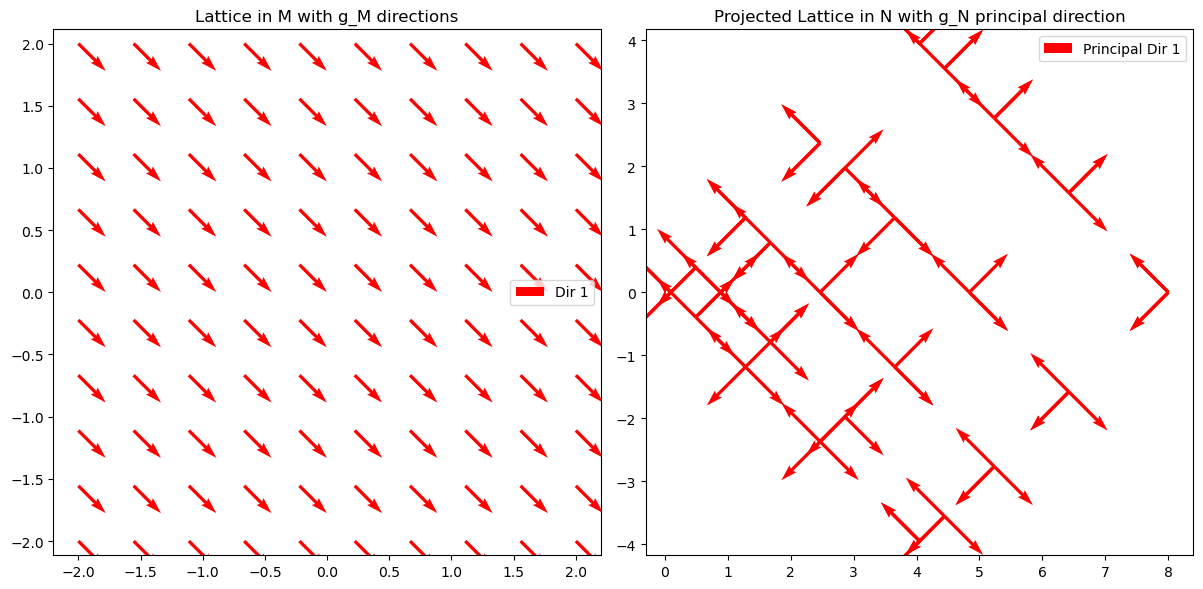

In [52]:
import numpy as np

def f(points):
    x, y = points
    return np.array([x**2 + y**2, x**2 - y**2])

def jacobian(x, y):
    """
    Compute the Jacobian for the function f at the point (x, y).
    """
    return np.array([[2*x, 2*y], [2*x, -2*y]])

g_M = np.array([[2, 0], [0, -2]])/4
# Create a lattice in M
x = np.linspace(-2, 2, 10)
y = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x, y)

# Compute g_N for each point on the lattice using the given diagonal g_M and the Jacobian
g_N_values = np.array([jacobian(x_val, y_val).T @ g_M @ jacobian(x_val, y_val) 
                       for x_val, y_val in zip(X.ravel(), Y.ravel())])
g_N_values = g_N_values.reshape(X.shape + (2, 2))

# Project the lattice to N
X_N, Y_N = f([X, Y])

# For the quiver plot, we will plot the principal directions of g_N
eigenvalues, eigenvectors = np.linalg.eigh(g_N_values)

# Create quiver plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original lattice with g_M directions
ax[0].quiver(X, Y, g_M[0, 0], g_M[1, 1], scale=10, color='r', label='Dir 1')
ax[0].set_title("Lattice in M with g_M directions")
ax[0].legend()
ax[0].axis('equal')

# Projected lattice with g_N directions
# We plot only the first principal direction for clarity
ax[1].quiver(X_N, Y_N, eigenvectors[:, :, 0, 0], eigenvectors[:, :, 0, 1], scale=10, color='r', label='Principal Dir 1')
ax[1].set_title("Projected Lattice in N with g_N principal direction")
ax[1].legend()
ax[1].axis('equal')

plt.tight_layout()
plt.show()


In [63]:
a = np.arange(8).reshape(2,2,2)

a = torch.from_numpy(a).float()
print(a)
print(torch.linalg.eigvalsh(a))

tensor([[[0., 1.],
         [2., 3.]],

        [[4., 5.],
         [6., 7.]]])
tensor([[-1.0000,  4.0000],
        [-0.6847, 11.6847]])


In [68]:
np.array([[1,1]]).repeat(10, axis=0)


array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])